## Monte Carlo Simulation - Time of Use Tariff

By benchmarking our algorithms performance, we can better evaluate the effectiveness and relevance of our results. In this notebook we evaluate two types of baseline:

- The Status Quo: Which emulates the control circuity currently present in HEMS.
- The random agent: Which makes random decisions at each time interval to charge/discharge the battery. 


The Stattus Quo benchmark is an importnt benchmark, since it represents the current operatio mode of most home-solar-battery systems in the field. Beating this benchmark shows that our methods can improve on the default methods in the field today. 

The Random Agent benchmark is equally important, as it gives an indication whether the agent is doing better than 'random guesses'. This is especially important for highly complex environments, where significant effort may be expended to model the complex environment and therefore the practitioner is interested to know the value of such efforts relative to the simplest approach (guessing). 

These benchmarks will be obtained for the simplistic pricing environment, where a time-of-use (ToU) tariff will be used to calculate the time varying reward for each action. This contrasts the wholesale pricing environment, which has an infinite range of pricing values at each time interval. 

#### System configuration:

In this simulation, we will simulate a household with solar and battery.

| Simulation | Status Quo | Random Agent 1 | Random Agent 2 |
| --- | --- | --- | --- |
| Battery Dischargeable | No | No | Yes|
| Battery Chargeable | No| No | Yes |


### Tarifff Types 

Tariffs are priced by region, and then by time of day. 

| State | Peak | Off-Peak | Shoulder | 
| --- | --- | --- | --- |
| SA | 6-10am, 3pm-1am | 1-6am | 10am-3pm |
| QLD | 4-8pm, Mon-Fri | 10-7am Mon-Sun | 7am-4pm, 8-10pm Mon-Fri,<br/> 7am-10pm Sat-Sun |
| VIC | 3-9pm | 9pm-3pm | N/A | 
| NSW | 2-8pm Mon-Fri | 10pm-7am | 7am-2pm, 8pm-10pm Mon-Fri,<br/>7am-10pm Sat-Sun |

Pricing was obtained for each region by analysing rates from major electricity retailers across australia. The prices shown below are in AUD, and are expressed in c/kWh supplied. 

| State | Peak | Off-Peak | Shoulder | Solar FiT | Connection |
| --- | --- | --- | --- | --- | --- |
| SA | 44.35 | 26.33 | 21.78 | 5.00 | 95.14 |
| QLD | 35.66 | 20.32 | 25.00 | 5 | 121.80 |
| VIC | 30.21 | 17.35 | N/A | 5.2 | 116.23 |  
| NSW | 62.34 | 16.42 | 28.39 | 5 | 104.8 |

### Status Quo Algorithm

Key System configuration:

- The battery can only discharge to meet the existing loads (no export), and
- The battery may only be charged by solar (no import)

Algorithm:
```python
for t in T:
    get solar, load at time t.
    Calculate net energy
    if t = 0
        initialise battery capacity as Full.
    get discharge/charge limits from battery. 
    update charge/discharge limits based on system confiiguration.
    Take an action
    Update Net energy, battery state. 
    Calculate reward, add to running sum.
```

In [1]:
## Automatically reload changes to class and restart Kernel
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import json
import random
import matplotlib.pyplot as plt

# Import the battery Class
import battery_sim

In [118]:
from datetime import datetime, time
import random

class reward:
    
    
    def __init__(self):
        """
        Initialize the reward module. 
        
        args: 
        
        """
        #self.region = region
        #self.tariff_type = tariff_type
        #self.export_tariff = export_tariff
        
        self.TOU = {
            "VIC":{"peak": 0.3021, "shoulder": 0.1735, "off-peak": 0.1735, 'solar':0.052, 'connection': 1.1623},
            "NSW":{"peak": 0.6234, "shoulder": 0.2839, "off-peak": 0.1642, 'solar':0.050, 'connection': 1.0480},
            "QLD":{"peak": 0.3566, "shoulder": 0.2500, "off-peak": 0.2032, 'solar':0.050, 'connection': 1.2180},
            "SA":{"peak": 0.4435, "shoulder": 0.2178, "off-peak": 0.2633, 'solar':0.050, 'connection': 0.9514}
        }
        
    def get_tariff_rate(self, current_timestamp, region):
        """
        Returns the Tariff Rate for a given region and timestamp, based on the ToU dict.
        
        inputs:
            current_timestamp (datetime.datetime): The time stamp including date and time. 
            region (str)
            
        return (float): The rate in $/kWh
        
        """
    
        current_time = current_timestamp.time()
        
        if region == 'VIC':
            # Only peak or shoulder/off-peak
            if self.time_between(time(15,0), time(21,0), current_time):
                return self.TOU['VIC']['peak']
            else: #shoulder/off-peak - either doesn't matter.
                return self.TOU['VIC']['shoulder']
            
        elif region == 'SA':
            # Determine whether peak, shoulder or off-peak
            if self.time_between(time(6,0), time(10,0), current_time) or self.time_between(time(15,0), time(1,0), current_time):                
                return self.TOU['SA']['peak']
            elif self.time_between(time(1,0), time(6,0), current_time):
                return self.TOU['SA']['off-peak']
            else: #shoulder
                return self.TOU['SA']['shoulder']
        
        else:
            # Either NSW or QLD which have weekday dependent peaks
            dow = current_timestamp.weekday()
            if region == 'QLD':
                if self.time_between(time(22,0), time(7,0), current_time):
                    return self.TOU['QLD']['off-peak']
                elif dow < 5 and self.time_between(time(16,0), time(20,0), current_time):
                    return self.TOU['QLD']['peak']
                else:
                    return self.TOU['QLD']['shoulder']
            
            elif region == 'NSW':
                # NSW only has a peak in winter and autum
                month = current_timestamp.month
                if self.time_between(time(22,0), time(7,0), current_time):
                    return self.TOU['NSW']['off-peak']
                # If it's a weekday, in peak time during the months of Summer or Winter. 
                elif dow < 5 and self.time_between(time(14,0), time(20,0), current_time) and month in [1,2,3,6,7,8,12]:
                    return self.TOU['NSW']['peak']
                else:
                    return self.TOU['NSW']['shoulder']             
            else:
                print('unknown region!')
                
            
    def get_solar_fit(self, region):
        """
        Returns the rate of reward for solar power exported in $/kWh by region
        region (str): The state as string
        """
        return self.TOU[f'{region}']['solar']
    
    def get_connection_fee(self, region):
        """
        Returns the daily connection fee in $/day
        region (str): The state as string
        
        """
        return self.TOU[f'{region}']['connection']           
    
    def time_between(self, begin_time, end_time, check_time):
        """
        Checks if a time is between two times. 
        from https://stackoverflow.com/questions/10048249/how-do-i-determine-if-current-time-is-within-a-specified-range-using-pythons-da

        """

        check_time = check_time
        if begin_time < end_time:
            return check_time >= begin_time and check_time <= end_time
        else: # crosses midnight
            return check_time >= begin_time or check_time <= end_time
        
        
def calculate_grid_load(solar, home, max_discharge, max_charge, scenario):
    """
    Function to return the action for the battery based off some strongly defined programming
    logic.
    args:
     solar - solar output at that time. Float, negative.
     home - household loads at that time Float, positive.
     max_discharge - discharge potential float, negative. ### Note the current code assumes positive.
     max_charge - charge potential of the battery float, positive.
     senario - string, describes which scenario is being modelled.
    
    """
    
    # Here the sign counts - make solar negative. 
    if solar > 0:
        solar = solar * -1
        
    net = home + solar
    
    if scenario == 'StatusQuo':
        """
        Battery cannot export or import energy.
        Must charge from solar and take max possible,
        Must meet loads to fullest extent.
        """

        # Surplus Load - we need to either import and/or discharge  
        if net > 0:
            state = 'discharge'
            if abs(max_discharge) >= net: # Deficit met by battery
                bat_output = - net
                grid = 0
            elif abs(max_discharge) < net: # Deficit not fully me by battery, need to import
                bat_output =  - max_discharge
                grid = net + bat_output

        # Surplus Solar - we need to either export, and/or charge
        elif net < 0:
            state = 'charge'
            if max_charge > abs(net): # Soak up all the excess solar, no export
                bat_output = - net
                grid = 0
            elif max_charge <= abs(net): # Soak up as much as we can, export the rest of the solar.
                bat_output = max_charge
                grid = net + bat_output

        else: # No load or solar, net = 0
            bat_output = 0
            grid=0
            state = 'standby'

    elif scenario == 'LimitedChargeRandomAgent':
        """
        Here we can only charge on solar and must take all solar.
        We cannot push system into export, but we don't have to meet all loads 
        """
        n_intervals = 10
        if solar > 0:
            solar = solar * -1
        
        net = home + solar
        # Surplus Load - we need to either import and/or discharge  
        if net > 0:
            state = 'discharge'
            if abs(max_discharge) >= net: # Deficit met by battery
                bat_limit = - net

            elif abs(max_discharge) < net: # Deficit not fully met by battery, need to import
                bat_limit =  - max_discharge
            
            # Vary how much we discharge by
            bat_output = random.sample(np.linspace(bat_limit, 0, n_intervals).tolist(), 1)[0]
            grid = net + bat_output

        # Surplus Solar - we need to either export, and/or charge - same as status quo
        elif net < 0:
            state = 'charge'
            if max_charge > abs(net): # Soak up all the excess solar, no export
                bat_output = - net
                grid = 0
            elif max_charge <= abs(net): # Soak up as much as we can, export the rest of the solar.
                bat_output = max_charge
                grid = net + bat_output

        else: # No load or solar, net = 0
            bat_output = 0
            grid=0
            state = 'standby'
    
    elif scenario == 'LimitedRandomAgent':
        """
        The same rules - battery cannot push system into further import or export.
        But can discharge or charge whenever it wants.
        """
        
        n_intervals = 10
        # Surplus Load - we need to either import and/or discharge  
        if net > 0:
            state = 'discharge'
            if abs(max_discharge) >= net: # Deficit met by battery
                bat_limit = - net

            elif abs(max_discharge) < net: # Deficit not fully me by battery, need to import
                bat_limit =  - max_discharge
            
            bat_output = random.sample(np.linspace(bat_limit, 0, n_intervals).tolist(), 1)[0]
            grid = net + bat_output

        # Surplus Solar - we need to either export, and/or charge
        elif net < 0:
            state = 'charge'
            if max_charge > abs(net): # Soak up all the excess solar, no export
                bat_limit = - net

            elif max_charge <= abs(net): # Soak up as much as we can, export the rest of the solar.
                bat_limit = max_charge

            bat_output = random.sample(np.linspace(0, bat_limit, n_intervals).tolist(), 1)[0]
            grid = net + bat_output

        else: # No load or solar, net = 0
            bat_output = 0
            grid=0
            state = 'standby'
    
    elif scenario == 'UnlimitedRandomAgent':
        
        """
        Currently doesn't work - Agent can do whatever it wants within the discharge and
        charge limits of the battery at that time. 
        """
        
        n_intervals = 10
        if solar > 0:
            solar = solar * -1
        
        net = home + solar
        
        # Limits  definied by battery charge/discharge rates
        bat_limit_lower =  - max_discharge
        bat_limit_upper = max_charge

        bat_output = random.sample(np.linspace(bat_limit_lower, bat_limit_upper, n_intervals).tolist(), 1)[0]
        grid = net + bat_output

        if bat_output < 0:
            state = 'discharge'
        elif bat_output > 0: 
            state = 'charge'
        else:
            state = 'standby'
    
    return grid, state, bat_output
                

In [59]:
## For Printing
rTOU = {
            "VIC":{"peak": 0.3021, "shoulder": 0.1735, "off-peak": 0.1735, 'solar':0.052, 'connection': 1.1623},
            "NSW":{"peak": 0.6234, "shoulder": 0.2839, "off-peak": 0.1642, 'solar':0.050, 'connection': 1.0480},
            "QLD":{"peak": 0.3566, "shoulder": 0.2500, "off-peak": 0.2032, 'solar':0.050, 'connection': 1.2180},
            "SA":{"peak": 0.4435, "shoulder": 0.2178, "off-peak": 0.2633, 'solar':0.050, 'connection': 0.9514}
        }

pd.DataFrame(rTOU)

In [4]:
# Load some data
path = "../home-energy-data/data/filtered_devices.parquet"
raw_df = pd.read_parquet(path)
raw_df.head()

,id,comms,model,phases,channels,latestStatus,firmwareVersion,shortEnergyReportingInterval,label,timezone,NumberPhases,FirstMeasurement
index,,,,,,,,,,,,
0,DD04108400839,"b'{""type"": ""cellular"", ""mode"": ""3G"", ""lastHear...",6M,"b'{""count"": 1, ""grouping"": [{""included"": [""DD0...","b'[{""id"": ""DD04108400839_C1"", ""label"": ""Grid"",...",1663883624,47.5.3,30,,Australia/Sydney,1,1622607600
1,DD04108401266,"b'{""type"": ""cellular"", ""mode"": ""3G"", ""lastHear...",6M,"b'{""count"": 1, ""grouping"": [{""included"": [""DD0...","b'[{""id"": ""DD04108401266_C1"", ""label"": ""Grid"",...",1663879662,47.5.3,30,,Australia/Melbourne,1,1619411700
3,DD04108624381,"b'{""type"": ""cellular"", ""mode"": ""3G"", ""lastHear...",6M,"b'{""count"": 1, ""grouping"": [{""included"": [""DD0...","b'[{""id"": ""DD04108624381_C1"", ""label"": ""Grid"",...",1663840553,47.5.3,30,,Australia/Sydney,1,1631839200
4,DD04108624683,"b'{""type"": ""cellular"", ""mode"": ""3G"", ""lastHear...",6M,"b'{""count"": 1, ""grouping"": [{""included"": [""DD0...","b'[{""id"": ""DD04108624683_C1"", ""label"": ""Grid"",...",1663852756,47.5.3,30,,Australia/Adelaide,1,1630990500
5,DD04108625556,"b'{""type"": ""cellular"", ""mode"": ""3G"", ""lastHear...",6M,"b'{""count"": 1, ""grouping"": [{""included"": [""DD0...","b'[{""id"": ""DD04108625556_C1"", ""label"": ""grid"",...",1663820382,47.5.3,30,,Australia/Sydney,1,1623129300


In [5]:
devices = []
region = ['NSW', 'VIC', 'SA', 'QLD']

# Get 1 deviceID for each region
for timezone in raw_df.timezone.value_counts().index:
    dev_id = raw_df[raw_df['timezone']==timezone]['id'].iloc[2]
    devices.append(dev_id)
    
# Create a dictionary:
device_dict = dict(zip(devices, region))
device_dict

{'DD04108625556': 'NSW',
 'DD14108625517': 'VIC',
 'DD34108399074': 'SA',
 'DD64108846336': 'QLD'}

In [6]:
# Now we have a list of test devices for each region, we can add all the data together
path = "../home-energy-data/data/full_ww_set.parquet"
data_df = pd.read_parquet(path)
data_df.head()

,Timestamp,Grid Consumption,Solar Consumption,Home Consumption,DeviceID
0,1619411700,0.04401,0.0,0.04401,DD04108401266
1,1619412000,0.04228,0.0,0.04228,DD04108401266
2,1619412300,0.04091,0.0,0.04091,DD04108401266
3,1619412600,0.03779,0.0,0.03779,DD04108401266
4,1619412900,0.03015,-0.0,0.03015,DD04108401266


In [7]:
# filter on devices in the device_dict:
# Create a copy
print('Creating a New dataframe with selected devices')
filtered_data = data_df[data_df['DeviceID'].isin(device_dict.keys())].copy()
# Add some new columns
filtered_data['region'] = filtered_data['DeviceID'].apply(lambda x: device_dict[f'{x}'])
filtered_data['datetime'] = filtered_data['Timestamp'].apply(lambda x: datetime.fromtimestamp(x))

# Get ToU tariff for each event
print('Done!\nGetting Tariffs...')
reward_instance = reward()
filtered_data['tariff'] = filtered_data.apply(lambda x: reward_instance.get_tariff_rate(x.datetime, x.region), axis=1)
filtered_data['solar tariff'] = filtered_data.apply(lambda x: reward_instance.get_solar_fit(x.region), axis=1)
filtered_data.head()

Creating a New dataframe with selected devices
Done!
Getting Tariffs...


,Timestamp,Grid Consumption,Solar Consumption,Home Consumption,DeviceID,region,datetime,tariff,solar tariff
368146,1623129300,-0.01408,-0.00032,0.01307,DD04108625556,NSW,2021-06-08 15:15:00,0.6234,0.05
368147,1623129600,-0.01326,-0.00044,0.01220,DD04108625556,NSW,2021-06-08 15:20:00,0.6234,0.05
368148,1623129900,-0.01245,-0.00049,0.01135,DD04108625556,NSW,2021-06-08 15:25:00,0.6234,0.05
368149,1623130200,-0.01219,-0.00054,0.01104,DD04108625556,NSW,2021-06-08 15:30:00,0.6234,0.05
368150,1623130500,-0.02626,0.00025,0.02616,DD04108625556,NSW,2021-06-08 15:35:00,0.6234,0.05


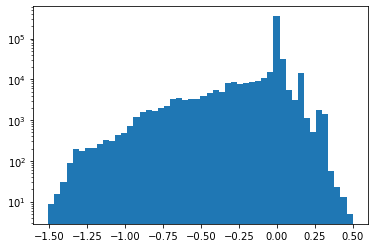

In [8]:
plt.hist(filtered_data['Grid Consumption'] - filtered_data['Solar Consumption'] - filtered_data['Home Consumption'], bins=50)
plt.yscale('log')

# EDA Decisions:

- We will ignore the Grid Consumption field, since this doesn't always match the Solar + Home consumption.
- We will ignore the noise in the solar channel - all values less than zero will be set to zero.
- There is an artefact of negative home consumption, for homes with only two channels connected - since the Home Consumption was calculated as the grid - solar, where there was excess solar, this made the home consumption negative, and this is misleading - it should instead be zero'd.
- This is not present in the NSW and SA datasets, so we will also set all negative home consumption values to zero. 

- There is a bug/error in the calculation for 2 channel homes- solar is subtracted from grid, but really they should be added!

In [9]:
# E.g. for Victoria, note there are only two channels:
json.loads(raw_df[raw_df['id']=='DD14108625517']['channels'].iloc[0])

[{'id': 'DD14108625517_C1',
  'label': 'Grid',
  'categoryId': 1,
  'categoryLabel': 'Grid connect',
  'ctRating': 60},
 {'id': 'DD14108625517_C2',
  'label': 'Solar',
  'categoryId': 5,
  'categoryLabel': 'Solar generation',
  'ctRating': 60},
 {'id': 'DD14108625517_C3',
  'label': 'Not Connected',
  'categoryId': 0,
  'categoryLabel': 'Not connected',
  'ctRating': 60},
 {'id': 'DD14108625517_C4',
  'label': 'Not Connected',
  'categoryId': 0,
  'categoryLabel': 'Not connected',
  'ctRating': 60},
 {'id': 'DD14108625517_C5',
  'label': 'Not Connected',
  'categoryId': 0,
  'categoryLabel': 'Not connected',
  'ctRating': 60},
 {'id': 'DD14108625517_C6',
  'label': 'Not Connected',
  'categoryId': 0,
  'categoryLabel': 'Not connected',
  'ctRating': 60}]

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0., 130515.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

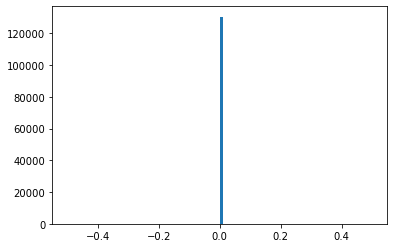

In [10]:
#  Note that basicallythe Home consumption is fabricated as we outlined. 
vic_df = filtered_data[filtered_data['region']=='VIC']
plt.hist(vic_df['Grid Consumption'] - vic_df['Solar Consumption'] - vic_df['Home Consumption'], bins=100)

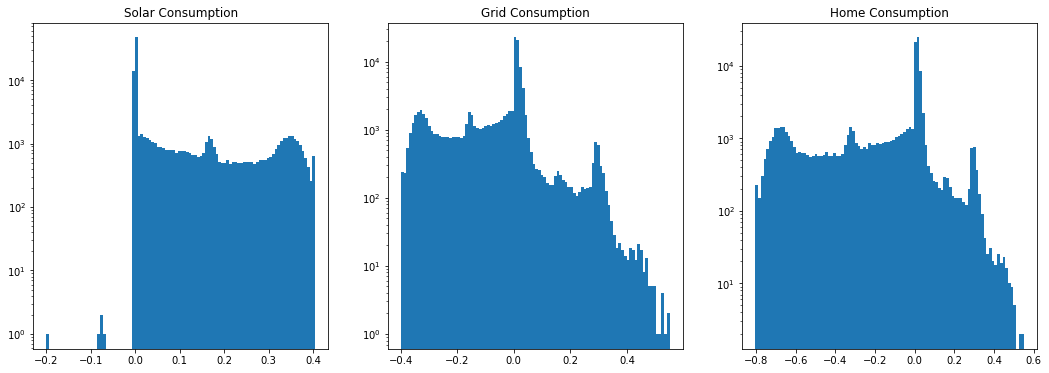

In [11]:
# Hence here the negative home and Solar consumption - which i'll later show is incorrect.
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,6))
plot_data = filtered_data[filtered_data['region']=='QLD']
plot_names = ['Solar Consumption', 'Grid Consumption', 'Home Consumption']
i = 0
for ax in (ax1, ax2, ax3):
    ax.hist(plot_data[f'{plot_names[i]}'], bins=100)
    ax.set_yscale('log')
    ax.set_title(f'{plot_names[i]}')
    i+=1

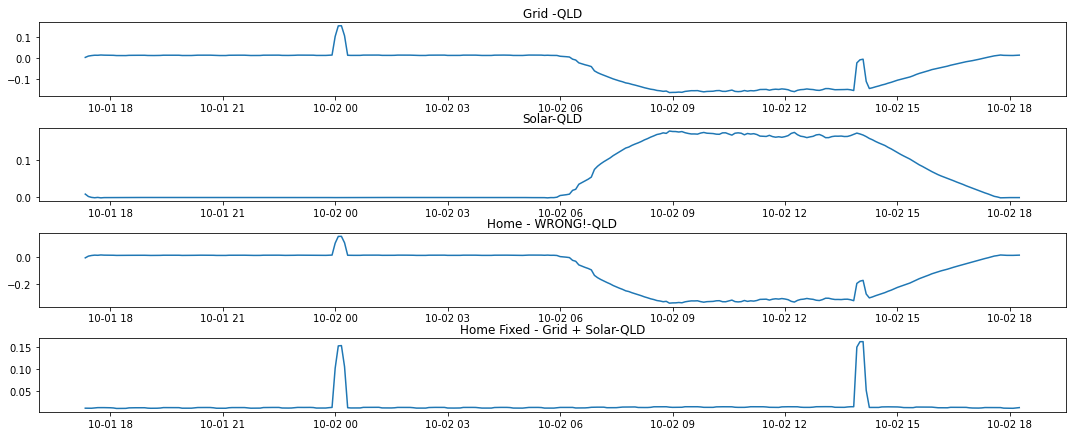

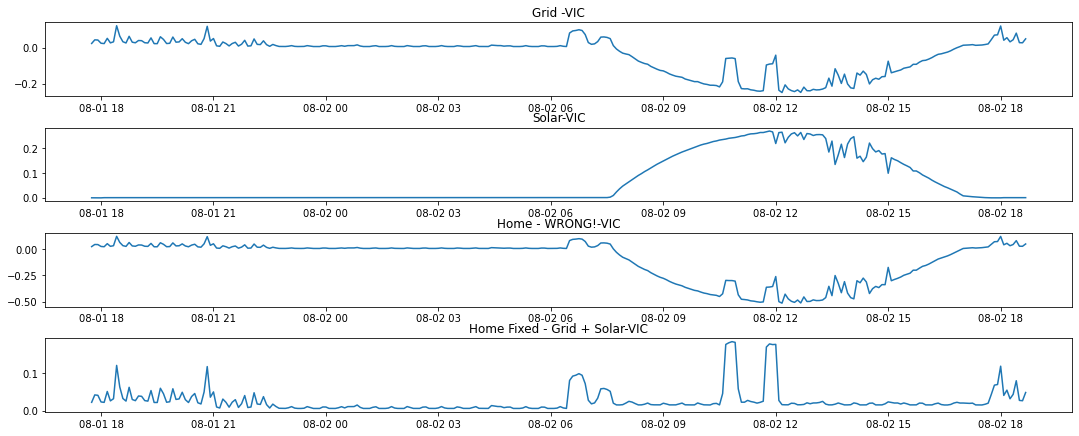

In [12]:
# here we can see that the aggregation is wrong for the 2 channel sites
# The home loads should never be negative. When we add the solar and grid together, we have fixed the problem.
# This occurs for QLD (here) and

filtered_data['dt'] = filtered_data['Timestamp'].apply(lambda x: datetime.fromtimestamp(x))

for data in ['QLD', 'VIC']:
    QLD_data = filtered_data[filtered_data['region'] == data]
    t = 9000

    x = QLD_data['dt'].tolist()[t:t+300]
    y1 = QLD_data['Grid Consumption'].tolist()[t:t+300]
    y2 = QLD_data['Home Consumption'].tolist()[t:t+300]
    y3 = QLD_data['Solar Consumption'].tolist()[t:t+300]
    y4 = np.array(y1) + np.array(y3)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=1, nrows=4, figsize=(15,6))
    fig.tight_layout()

    ax1.plot(x, y1)
    ax1.set_title(f'Grid -{data}')
    ax3.plot(x, y2)
    ax3.set_title(f'Home - WRONG!-{data}')
    ax2.plot(x, y3)
    ax2.set_title(f'Solar-{data}')
    ax4.plot(x, y4)
    ax4.set_title(f'Home Fixed - Grid + Solar-{data}')

In [13]:
## For Vic and QLD, we need to rewrite the Home Consumption data channels
region_filter = filtered_data['region'].isin(['QLD','VIC'])
filtered_data.loc[region_filter,'Home Consumption'] =filtered_data.loc[region_filter,'Grid Consumption'] + filtered_data.loc[region_filter,'Solar Consumption']

In [14]:
## Then we make all negative values in the Home Consumption and Solar Consumption channels = 0
filtered_data.loc[filtered_data['Home Consumption'] < 0, 'Home Consumption'] = 0
filtered_data.loc[filtered_data['Solar Consumption'] < 0, 'Solar Consumption'] = 0

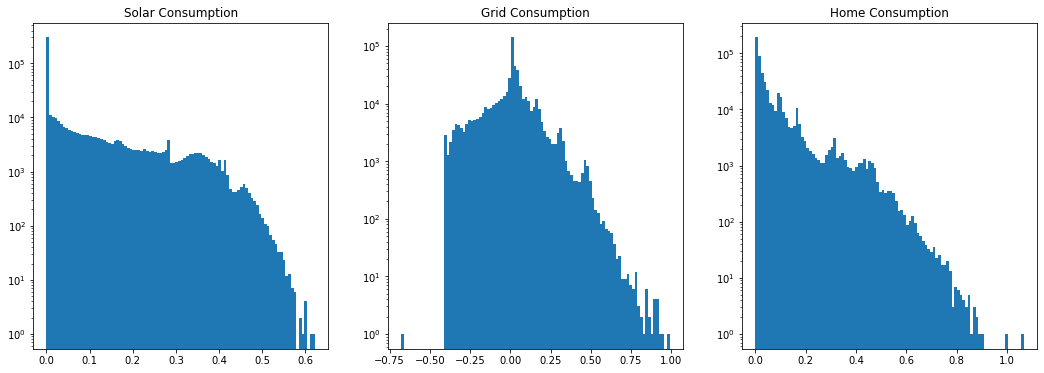

In [15]:
## Fixed View of the data
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,6))

plot_names = ['Solar Consumption', 'Grid Consumption', 'Home Consumption']
i = 0
for ax in (ax1, ax2, ax3):
    ax.hist(filtered_data[f'{plot_names[i]}'], bins=100)
    ax.set_yscale('log')
    ax.set_title(f'{plot_names[i]}')
    i+=1

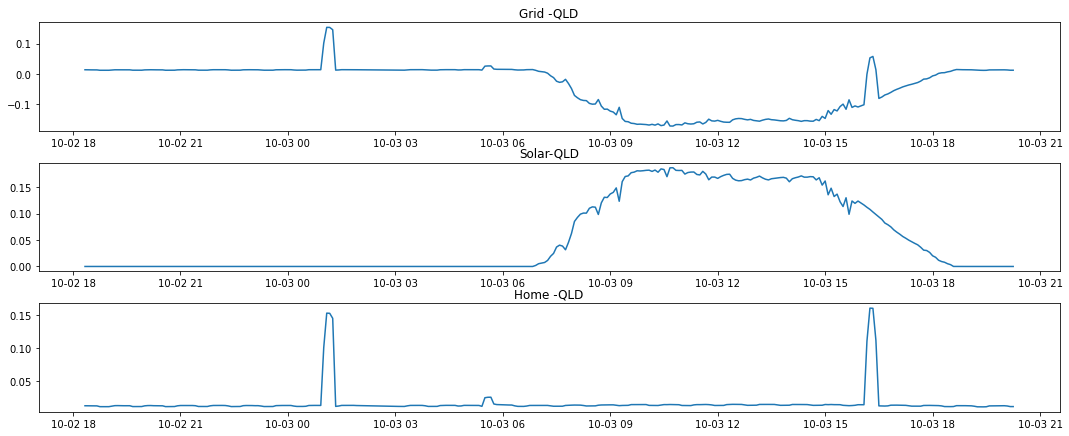

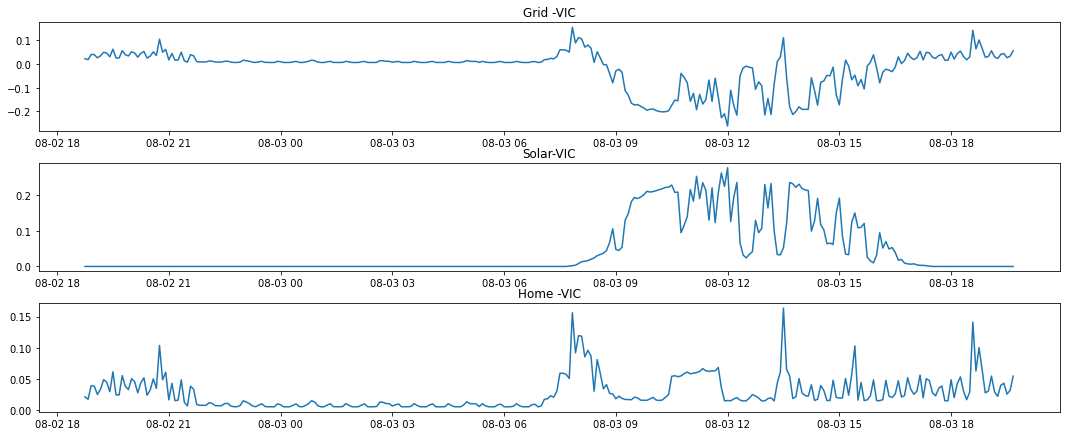

In [16]:
# here we can see that the aggregation is wrong for the 2 channel sites
# The home loads should never be negative. When we add the solar and grid together, we have fixed the problem.
# This occurs for QLD (here) and

filtered_data['dt'] = filtered_data['Timestamp'].apply(lambda x: datetime.fromtimestamp(x))

for data in ['QLD', 'VIC']:
    QLD_data = filtered_data[filtered_data['region'] == data]
    t = 9300

    x = QLD_data['dt'].tolist()[t:t+300]
    y1 = QLD_data['Grid Consumption'].tolist()[t:t+300]
    y2 = QLD_data['Home Consumption'].tolist()[t:t+300]
    y3 = QLD_data['Solar Consumption'].tolist()[t:t+300]

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(15,6))
    fig.tight_layout()

    ax1.plot(x, y1)
    ax1.set_title(f'Grid -{data}')
    ax3.plot(x, y2)
    ax3.set_title(f'Home -{data}')
    ax2.plot(x, y3)
    ax2.set_title(f'Solar-{data}')

In [17]:
filtered_data[['Grid Consumption', 'Solar Consumption','Home Consumption', 'region']].groupby('region').agg(sum)

,Grid Consumption,Solar Consumption,Home Consumption
region,,,
NSW,2404.01462,10210.88777,15979.96860
QLD,-6460.10887,10134.65343,3666.75073
SA,5338.36235,10336.50705,7689.00383
VIC,-446.71809,6514.28013,6038.81061


In [18]:
eda_df = filtered_data[['Solar Consumption','Home Consumption', 'region']].copy()
eda_df['Net Consumption'] = eda_df['Home Consumption'] - eda_df['Solar Consumption']

In [19]:
eda_df.groupby('region').agg(sum)

,Solar Consumption,Home Consumption,Net Consumption
region,,,
NSW,10210.88777,15979.96860,5769.08083
QLD,10134.65343,3666.75073,-6467.90270
SA,10336.50705,7689.00383,-2647.50322
VIC,6514.28013,6038.81061,-475.46952


In [20]:
filtered_data

,Timestamp,Grid Consumption,Solar Consumption,Home Consumption,DeviceID,region,datetime,tariff,solar tariff,dt
368146,1623129300,-0.01408,0.00000,0.01307,DD04108625556,NSW,2021-06-08 15:15:00,0.6234,0.05,2021-06-08 15:15:00
368147,1623129600,-0.01326,0.00000,0.01220,DD04108625556,NSW,2021-06-08 15:20:00,0.6234,0.05,2021-06-08 15:20:00
368148,1623129900,-0.01245,0.00000,0.01135,DD04108625556,NSW,2021-06-08 15:25:00,0.6234,0.05,2021-06-08 15:25:00
368149,1623130200,-0.01219,0.00000,0.01104,DD04108625556,NSW,2021-06-08 15:30:00,0.6234,0.05,2021-06-08 15:30:00
368150,1623130500,-0.02626,0.00025,0.02616,DD04108625556,NSW,2021-06-08 15:35:00,0.6234,0.05,2021-06-08 15:35:00
...,...,...,...,...,...,...,...,...,...,...
8552584,1664238900,-0.14530,0.15453,0.00923,DD64108846336,QLD,2022-09-27 10:35:00,0.2500,0.05,2022-09-27 10:35:00
8552585,1664239200,-0.15365,0.16305,0.00940,DD64108846336,QLD,2022-09-27 10:40:00,0.2500,0.05,2022-09-27 10:40:00
8552586,1664239500,-0.19958,0.20921,0.00963,DD64108846336,QLD,2022-09-27 10:45:00,0.2500,0.05,2022-09-27 10:45:00
8552587,1664239800,-0.27848,0.28866,0.01018,DD64108846336,QLD,2022-09-27 10:50:00,0.2500,0.05,2022-09-27 10:50:00


In [21]:
# Current Costs
# When Grid consumption > 0, then we imported energy. @ the import tariff
# When Grid consumption < 0, then we exported solar @ the solar tariff

def calc_reward(df):
    
    net = df['Home Consumption'] - df['Solar Consumption']
    if net >= 0:
        reward = net * df['tariff']
    else: # Don't need to negate
        reward = net * df['solar tariff']
    return reward

print('Done!\nCalculating current bill...')
filtered_data['Historic Reward'] = filtered_data.apply(lambda x: calc_reward(x), axis=1)
print('Done!')

# Show historic bill
summary_df = filtered_data[['DeviceID','region','Historic Reward']].groupby(['DeviceID', 'region']).agg('sum').reset_index().copy()
# Number of days -> filtered_data['DeviceID'].value_counts() / (24 * 12)
summary_df

Done!
Calculating current bill...
Done!


,DeviceID,region,Historic Reward
0,DD04108625556,NSW,2794.971225
1,DD14108625517,VIC,644.530154
2,DD34108399074,SA,1329.293242
3,DD64108846336,QLD,137.962843


In [61]:
filtered_data['DeviceID'].value_counts() / (24 * 12)

DD34108399074    545.479167
DD04108625556    475.927083
DD14108625517    453.177083
DD64108846336    391.965278
Name: DeviceID, dtype: float64

```
for t in T:
    get solar, load at time t.
    Calculate net energy
    if t = 0
        initialise battery capacity as Full.
    get discharge/charge limits from battery. 
    update charge/discharge limits based on system confiiguration.
    Take an action
    Update Net energy, battery state. 
    Calculate reward, add to running sum.
    
```

In [22]:
# Code for checking for missing timestamps:
#my_values = np.array(device_data['Timestamp'].tolist())
#pd.DataFrame([my_values[1:][x] - my_values[x] for x in range(len(my_values[1:]))]).value_counts()

## Create some new columns to collect actions
result_dict =  {
    'Timestamp':[], 'DeviceID':[], 'Solar':[], 'Home':[], 'Tariff':[], 'Solar Tariff':[],
    'Battery Capacity':[],'Battery Available Energy':[], 'Grid Simulated':[], 
    'Action':[],'State':[], 'Limits':[], 'Reward':[]
}  

for device in device_dict.keys():
    # Create a new dataframe for that device
    device_data = filtered_data[filtered_data['DeviceID'] == device].copy()
    # Make sure that the measurements are in order. 
    device_data.sort_values('Timestamp', inplace=True)
    
    reward = 0
    reward_total = 0
    print(f'Device: {device}')
    
    bat = None
    debug = False

    for m in device_data.index:

        # Get Solar, and Load, caculate the net energy
        sol = device_data.loc[m]['Solar Consumption']
        hom = device_data.loc[m]['Home Consumption']
        ToU = device_data.loc[m]['tariff']
        sToU = device_data.loc[m]['solar tariff']
        net = hom - sol 

        # Instantiate Battery the first time
        if bat == None:
            bat = battery_sim.battery(capacity=14,dischargeable=False, importable=False)
            bat.avl_energy = 14 # kWh
            print(f'Battery Initialised: Available Energy {bat.avl_energy} kWh')

        # Get discharge/charge limits from the battery:
        a_d, a_c = bat.get_limits(-sol, hom)

        # Update Resolve Action
        grid, state, bat_out = calculate_grid_load(sol, hom, a_d, a_c, 'StatusQuo' )

        if debug:
            print(f'Original Solar: {sol}, Home: {hom}, Net: {net}')
            print(f" Bat Capacity: {bat.avl_energy}, Limits: {a_d}/{a_c}, Bat Capacity: {bat.capacity}")
            print(f'Modified Solar: {sol}, Home: {hom},Grid: {grid}, Action:{state} {bat_out}')

        # Update State
        if state == 'charge':
            bat.charge_(abs(bat_out))
            reward = grid * sToU
        elif state == 'discharge':
            bat.discharge_(abs(bat_out))
            reward = grid * ToU
        else:
            reward = 0
        reward_total += reward
        
        # Write values to results dictionary:
        i = 0
        val = [m, device, sol, hom, ToU, sToU, bat.capacity, bat.avl_energy, grid, bat_out,state, (a_d, a_c), reward]
        for key in result_dict:
            result_dict[key].append(val[i])
            i += 1

        if debug:
            print(f"reward: {reward}")
            print('-----')
    print(f'Revised bill: ${reward_total:.2f}')
print('done!')

Device: DD04108625556
Battery Initialised: Available Energy 14 kWh
Revised bill: $2023.71
Device: DD14108625517
Battery Initialised: Available Energy 14 kWh
Revised bill: $354.36
Device: DD34108399074
Battery Initialised: Available Energy 14 kWh
Revised bill: $956.56
Device: DD64108846336
Battery Initialised: Available Energy 14 kWh
Revised bill: $-273.86
done!


In [23]:
result_df = pd.DataFrame(result_dict)

In [24]:
result_df[['DeviceID', 'Solar', 'Reward']].groupby('DeviceID').agg(sum)

,Solar,Reward
DeviceID,,
DD04108625556,10210.88777,2023.706860
DD14108625517,6514.28013,354.364586
DD34108399074,10336.50705,956.564054
DD64108846336,10134.65343,-273.857821


In [25]:
result_df[['DeviceID','Solar','Battery Available Energy']].groupby('DeviceID').agg(['max','min','median', 'mean'])

Solar                         Battery Available Energy  \
                   max  min   median      mean                      max   
DeviceID                                                                  
DD04108625556  0.62258  0.0  0.00000  0.074496                   13.997   
DD14108625517  0.28387  0.0  0.00000  0.049912                   14.000   
DD34108399074  0.41876  0.0  0.00000  0.065797                   14.000   
DD64108846336  0.40384  0.0  0.00001  0.089778                   14.000   

                                                   
                        min     median       mean  
DeviceID                                           
DD04108625556 -2.775558e-17   1.456518   4.067233  
DD14108625517 -1.387779e-17  10.570479   7.830334  
DD34108399074 -5.551115e-17  11.917661   8.550077  
DD64108846336 -1.734723e-18  12.352867  11.092218

In [26]:
result_df.to_csv('ToU_Simulation_04OCT22.csv')

In [27]:
# Code for checking for missing timestamps:
#my_values = np.array(device_data['Timestamp'].tolist())
#pd.DataFrame([my_values[1:][x] - my_values[x] for x in range(len(my_values[1:]))]).value_counts()

In [30]:
## Monte Carlo Simulation

## Create some new columns to collect actions
mc_dict = {'DeviceID':[], 'SimulationNo.':[], 'Simulated Total Reward':[]}

result_dict =  {
    'Timestamp':[], 'DeviceID':[], 'Solar':[], 'Home':[], 'Tariff':[], 'Solar Tariff':[],
    'Battery Capacity':[],'Battery Available Energy':[], 'Grid Simulated':[], 
    'Action':[],'State':[], 'Limits':[], 'Reward':[]
}

high_res_log = False

n_simulations = 100

# Simulate a random 
print('Starting Monte Carlo Simulation')

for device in device_dict.keys():
    # Create a new dataframe for that device
    device_data = filtered_data[filtered_data['DeviceID'] == device].copy()
    # Make sure that the measurements are in order. 
    device_data.sort_values('Timestamp', inplace=True)

    bat = None
    debug = False
    
    for sim in range(n_simulations):
        reward_total = 0
        
        for m in device_data.index:

            # Get Solar, and Load, caculate the net energy
            sol = device_data.loc[m]['Solar Consumption']
            hom = device_data.loc[m]['Home Consumption']
            ToU = device_data.loc[m]['tariff']
            sToU = device_data.loc[m]['solar tariff']
            net = hom - sol 

            # Instantiate Battery the first time
            if bat == None:
                bat = battery_sim.battery(capacity=14,dischargeable=False, importable=False)
                bat.avl_energy = 14 # kWh
                #print(f'Battery Initialised: Available Energy {bat.avl_energy} kWh')

            # Get discharge/charge limits from the battery:
            a_d, a_c = bat.get_limits(-sol, hom)

            # Update Resolve Action
            grid, state, bat_out = calculate_grid_load(sol, hom, a_d, a_c, 'LimitedRandomAgent' )

            if debug:
                print(f'Original Solar: {sol}, Home: {hom}, Net: {net}')
                print(f" Bat Available: {bat.avl_energy}, Limits: {a_d}/{a_c}, Bat Capacity: {bat.capacity}")
                print(f'Modified Solar: {sol}, Home: {hom},Grid: {grid}, Action:{state} {bat_out}')

            # Update State
            if state == 'charge':
                bat.charge_(abs(bat_out))
                reward = grid * sToU
            elif state == 'discharge':
                bat.discharge_(abs(bat_out))
                reward = grid * ToU
            else:
                reward = 0
            reward_total += reward

            # Write values to results dictionary:
            if high_res_log:
                i = 0
                val = [m, device, sol, hom, ToU, sToU, bat.capacity, bat.avl_energy, grid, bat_out,state, (a_d, a_c), reward]
                for key in result_dict:
                    result_dict[key].append(val[i])
                    i += 1

        j = 0
        log_vals = [device, sim, reward_total]
        for key in mc_dict:
            mc_dict[key].append(log_vals[j])
            j += 1
            
        print(f'Device: {device}, Revised bill: ${reward_total:.2f}, Simulation Number: {sim+1} of {n_simulations}')
        
print('done!')

Starting Monte Carlo Simulation
Device: DD04108625556, Revised bill: $2394.76, Simulation Number: 1 of 100
Device: DD04108625556, Revised bill: $4791.85, Simulation Number: 2 of 100
Device: DD04108625556, Revised bill: $7186.86, Simulation Number: 3 of 100
Device: DD04108625556, Revised bill: $9581.25, Simulation Number: 4 of 100
Device: DD04108625556, Revised bill: $11972.75, Simulation Number: 5 of 100
Device: DD04108625556, Revised bill: $14368.82, Simulation Number: 6 of 100
Device: DD04108625556, Revised bill: $16758.49, Simulation Number: 7 of 100
Device: DD04108625556, Revised bill: $19155.50, Simulation Number: 8 of 100
Device: DD04108625556, Revised bill: $21556.31, Simulation Number: 9 of 100
Device: DD04108625556, Revised bill: $23950.60, Simulation Number: 10 of 100
Device: DD04108625556, Revised bill: $26341.68, Simulation Number: 11 of 100
Device: DD04108625556, Revised bill: $28735.79, Simulation Number: 12 of 100
Device: DD04108625556, Revised bill: $31133.88, Simulatio

In [74]:
## Fix for previous simulation which accidentally calculated a high running total which did not reset between simulations.

dev_list = []
for device in mc_df['DeviceID'].unique():
    data = mc_df.loc[mc_df['DeviceID']==device,'Simulated Total Reward'].to_list()
    data_fixed = [x - data[i - 1] for i, x in enumerate(data)][1:]
    dev_list.append({device:data_fixed})
    
concat_df = pd.DataFrame()
for i in [0,1,2,3]:
    df_a = pd.DataFrame(dev_list[i]).unstack(-1).reset_index()[['level_0',0]]
    concat_df = pd.concat([concat_df,df_a], axis=0)
    
concat_df.columns = ['DeviceID','Simulated Total Reward']
concat_df

In [105]:
concat_df.groupby('DeviceID')['Simulated Total Reward'].agg(['mean', 'median','max', 'min', 'std'] )

,mean,median,max,min,std
DeviceID,,,,,
DD04108625556,2459.510149,2402.908051,2794.971225,2389.668529,137.775619
DD14108625517,502.007528,502.074925,504.348559,500.323921,0.780138
DD34108399074,1143.738435,1144.062669,1151.264132,1135.145804,3.459201
DD64108846336,-72.154662,-72.321119,-68.665070,-75.105851,1.399148


In [119]:
## Monte Carlo Simulation

## Create some new columns to collect actions
mc_dict = {'DeviceID':[], 'SimulationNo.':[], 'Simulated Total Reward':[]}

result_dict =  {
    'Timestamp':[], 'DeviceID':[], 'Solar':[], 'Home':[], 'Tariff':[], 'Solar Tariff':[],
    'Battery Capacity':[],'Battery Available Energy':[], 'Grid Simulated':[], 
    'Action':[],'State':[], 'Limits':[], 'Reward':[]
}

high_res_log = False

n_simulations = 100

# Simulate a random 
print('Starting Monte Carlo Simulation')

for device in device_dict.keys():
    # Create a new dataframe for that device
    device_data = filtered_data[filtered_data['DeviceID'] == device].copy()
    # Make sure that the measurements are in order. 
    device_data.sort_values('Timestamp', inplace=True)

    bat = None
    debug = False
    
    for sim in range(n_simulations):
        
        reward_total = 0
        for m in device_data.index:

            # Get Solar, and Load, caculate the net energy
            sol = device_data.loc[m]['Solar Consumption']
            hom = device_data.loc[m]['Home Consumption']
            ToU = device_data.loc[m]['tariff']
            sToU = device_data.loc[m]['solar tariff']
            net = hom - sol 

            # Instantiate Battery the first time
            if bat == None:
                bat = battery_sim.battery(capacity=14,dischargeable=False, importable=False)
                bat.avl_energy = 14 # kWh
                #print(f'Battery Initialised: Available Energy {bat.avl_energy} kWh')

            # Get discharge/charge limits from the battery:
            a_d, a_c = bat.get_limits(-sol, hom)

            # Update Resolve Action
            grid, state, bat_out = calculate_grid_load(sol, hom, a_d, a_c, 'LimitedChargeRandomAgent')

            if debug:
                print(f'Original Solar: {sol}, Home: {hom}, Net: {net}')
                print(f" Bat Available: {bat.avl_energy}, Limits: {a_d}/{a_c}, Bat Capacity: {bat.capacity}")
                print(f'Modified Solar: {sol}, Home: {hom},Grid: {grid}, Action:{state} {bat_out}')

            # Update State
            if state == 'charge':
                bat.charge_(abs(bat_out))
                reward = grid * sToU
            elif state == 'discharge':
                bat.discharge_(abs(bat_out))
                reward = grid * ToU
            else:
                reward = 0
            reward_total += reward

            # Write values to results dictionary:
            if high_res_log:
                i = 0
                val = [m, device, sol, hom, ToU, sToU, bat.capacity, bat.avl_energy, grid, bat_out,state, (a_d, a_c), reward]
                for key in result_dict:
                    result_dict[key].append(val[i])
                    i += 1

        j = 0
        log_vals = [device, sim, reward_total]
        for key in mc_dict:
            mc_dict[key].append(log_vals[j])
            j += 1
            
        print(f'Device: {device}, Revised bill: ${reward_total:.2f}, Simulation Number: {sim+1} of {n_simulations}')
        
print('done!')

Starting Monte Carlo Simulation
Device: DD04108625556, Revised bill: $2277.01, Simulation Number: 1 of 100
Device: DD04108625556, Revised bill: $2273.52, Simulation Number: 2 of 100
Device: DD04108625556, Revised bill: $2280.86, Simulation Number: 3 of 100
Device: DD04108625556, Revised bill: $2269.88, Simulation Number: 4 of 100
Device: DD04108625556, Revised bill: $2281.15, Simulation Number: 5 of 100
Device: DD04108625556, Revised bill: $2276.62, Simulation Number: 6 of 100
Device: DD04108625556, Revised bill: $2283.81, Simulation Number: 7 of 100
Device: DD04108625556, Revised bill: $2274.75, Simulation Number: 8 of 100
Device: DD04108625556, Revised bill: $2276.53, Simulation Number: 9 of 100
Device: DD04108625556, Revised bill: $2278.06, Simulation Number: 10 of 100
Device: DD04108625556, Revised bill: $2276.87, Simulation Number: 11 of 100
Device: DD04108625556, Revised bill: $2280.10, Simulation Number: 12 of 100
Device: DD04108625556, Revised bill: $2275.18, Simulation Number:

In [ ]:
"""## Monte Carlo Simulation

## Create some new columns to collect actions
mc_dict = {'DeviceID':[], 'SimulationNo.':[], 'Simulated Total Reward':[]}

result_dict =  {
    'Timestamp':[], 'DeviceID':[], 'Solar':[], 'Home':[], 'Tariff':[], 'Solar Tariff':[],
    'Battery Capacity':[],'Battery Available Energy':[], 'Grid Simulated':[], 
    'Action':[],'State':[], 'Limits':[], 'Reward':[]
}

high_res_log = False

n_simulations = 10

# Simulate a random 
print('Starting Monte Carlo Simulation')

for device in device_dict.keys():
    # Create a new dataframe for that device
    device_data = filtered_data[filtered_data['DeviceID'] == device].copy()
    # Make sure that the measurements are in order. 
    device_data.sort_values('Timestamp', inplace=True)

    reward = 0
    reward_total = 0
    #print(f'Device: {device}')

    bat = None
    debug = False
    for sim in range(n_simulations):
        for m in device_data.index:

            # Get Solar, and Load, caculate the net energy
            sol = device_data.loc[m]['Solar Consumption']
            hom = device_data.loc[m]['Home Consumption']
            ToU = device_data.loc[m]['tariff']
            sToU = device_data.loc[m]['solar tariff']
            net = hom - sol 

            # Instantiate Battery the first time
            if bat == None:
                bat = battery_sim.battery(capacity=14,dischargeable=False, importable=False)
                bat.avl_energy = 14 # kWh
                #print(f'Battery Initialised: Available Energy {bat.avl_energy} kWh')

            # Get discharge/charge limits from the battery:
            a_d, a_c = bat.get_limits(-sol, hom)

            # Update Resolve Action
            grid, state, bat_out = calculate_grid_load(sol, hom, a_d, a_c, 'UnlimitedRandomAgent' )

            if debug:
                print(f'Original Solar: {sol}, Home: {hom}, Net: {net}')
                print(f" Bat Available: {bat.avl_energy}, Limits: {a_d}/{a_c}, Bat Capacity: {bat.capacity}")
                print(f'Modified Solar: {sol}, Home: {hom},Grid: {grid}, Action:{state} {bat_out}')

            # Update State
            if state == 'charge':
                bat.charge_(abs(bat_out))
                reward = grid * sToU
            elif state == 'discharge':
                bat.discharge_(abs(bat_out))
                reward = grid * ToU
            else:
                reward = 0
            reward_total += reward

            # Write values to results dictionary:
            if high_res_log:
                i = 0
                val = [m, device, sol, hom, ToU, sToU, bat.capacity, bat.avl_energy, grid, bat_out,state, (a_d, a_c), reward]
                for key in result_dict:
                    result_dict[key].append(val[i])
                    i += 1

        j = 0
        log_vals = [device, sim, reward_total]
        for key in mc_dict:
            mc_dict[key].append(log_vals[j])
            j += 1
            
        print(f'Device: {device}, Revised bill: ${reward_total:.2f}, Simulation Number: {sim+1} of {n_simulations}')
        
print('done!')"""